
### Setting up the environment

In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
import seaborn as sns
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
import ijson
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5


### Cleaning the data script

In [2]:
import json
if False :
    write_csv = open('processed/kick.csv','w')
    json_file_path = '/home/rh0101/accion-dev/j-books/pydata-talk/data/Kickstarter_2017-10-15T10_20_38_271Z.json'

    headers= 'id,deadline,launched_at,state,category_type_subtype,location_type,backers_count,currency,goal,pledged,spotlight,static_usd_rate,usd_pledged,country,country_state\n'

    write_csv.write(headers)

    for line in open(json_file_path):
      obj = json.loads(line)
      temp_data = []
      try :
        temp_data.append(str(obj["data"]["id"]))
        temp_data.append(str(obj["data"]["deadline"]))
        temp_data.append(str(obj["data"]["launched_at"]))
        temp_data.append(str(obj["data"]["state"]))
        temp_data.append(str(obj["data"]["category"]["slug"]))
        try :
            temp_data.append(str(obj["data"]["location"]["type"]))
        except Exception as e:
            temp_data.append('None')
        temp_data.append(str(obj["data"]["backers_count"]))
        temp_data.append(str(obj["data"]["currency"]))
        temp_data.append(str(obj["data"]["goal"]))
        temp_data.append(str(obj["data"]["pledged"]))
        temp_data.append(str(obj["data"]["spotlight"]))
        temp_data.append(str(obj["data"]["static_usd_rate"]))
        temp_data.append(str(obj["data"]["usd_pledged"]))
        temp_data.append(str(obj["data"]["country"]))
        try:
            temp_data.append(str(obj["data"]["location"]["localized_name"]))
        except Exception as e:
            temp_data.append('None')
        write_csv.write(','.join(temp_data) + '\n')
      except Exception as e:
        print('error', e)

    write_csv.close()


### Importing Dataset

In [143]:
# import dataset
kickstarter_file_path = '/home/rh0101/dev/blog-code/kickstarter-exploritory-analysis/processed/kick.csv'

kick_df = pd.read_csv(kickstarter_file_path)

In [144]:
kick_df.head()

,id,deadline,launched_at,state,category_type_subtype,location_type,backers_count,currency,goal,pledged,spotlight,static_usd_rate,usd_pledged,country,country_state
0,1361433686,1477591896,1474999896,successful,art/digital art,Town,121,EUR,"5,000.00","5,000.37",True,1.12,"5,617.45",FR,Paris
1,1851713855,1481389611,1476202011,successful,art/digital art,Town,7,GBP,100.00,127.00,True,1.24,157.72,GB,Bournemouth
2,675977754,1479693600,1476895843,successful,art/digital art,Town,201,CAD,"12,000.00","12,536.32",True,0.76,"9,566.01",CA,Montreal
3,158101895,1480762373,1478166773,successful,art/digital art,Town,31,USD,300.00,346.00,True,1.00,346.00,US,Philadelphia
4,656509465,1481543007,1478951007,successful,art/digital art,Town,16,GBP,500.00,500.00,True,1.26,628.21,GB,London


### Cleaning and Transforming data

#### Extracting category type and subtypes

In [145]:
kick_df['category_type'] = kick_df['category_type_subtype'].apply(lambda x: x.split('/')[0])
kick_df['category_subtype'] = kick_df['category_type_subtype'].apply(lambda x: x.split('/')[1])

#### Fixing date time columns

In [146]:
kick_df['deadline'] = pd.to_datetime(kick_df['deadline'], unit='s', )
kick_df['launched_at'] = pd.to_datetime(kick_df['launched_at'], unit='s', )
# drop the redundant column
kick_df.drop(['category_type_subtype'], axis=1, inplace=True)

#### Changing dtype of series

In [147]:
# change the resolution of the floating point number
kick_df["goal"] = kick_df["goal"].astype("float32")
kick_df["pledged"] = kick_df["pledged"].astype("float32")
kick_df["usd_pledged"] = kick_df["usd_pledged"].astype("float32")

#### Dealing with missing values

In [148]:
kick_df.replace('None',np.NaN, inplace=True)

In [149]:
kick_df.isnull().sum()

id                    0
deadline              0
launched_at           0
state                 0
location_type       681
backers_count         0
currency              0
goal                  0
pledged               0
spotlight             0
static_usd_rate       0
usd_pledged           0
country               0
country_state       681
category_type         0
category_subtype      0
dtype: int64

In [150]:
kick_df.dropna(inplace=True)

#### Fixing Categorical variables

In [151]:
category_variables = ['country','category_subtype','category_type','location_type','country_state','state','currency']
for cat_var in category_variables:
    kick_df[cat_var] = kick_df[cat_var].astype('category')

### Variables of interest

In [12]:
##  [1] "id"                            "backers_count"                
##  [3] "country"                       "creator.failed_experience"    
##  [5] "creator.id"                    "creator.successful_experience"
##  [7] "creator.total_experience"      "currency"                     
##  [9] "deadline"                      "goal"                         
## [11] "launched_at"                   "pledged"                      
## [13] "slug"                          "spotlight"                    
## [15] "state"                         "static_usd_rate"              
## [17] "usd_goal"                      "usd_pledged"                  
## [19] "category_name"                 "location_country"             
## [21] "location_type"                 "location_name"                
## [23] "category_parent"               "launched_at_month"            
## [25] "launched_at_year"              "launched_weekday"             
## [27] "deadline_weekday"

#### Project state distribution

In [13]:
kick_df.groupby('state')['id'].count().sort_values(ascending=False)

state
successful    73272
failed        70305
canceled       8666
live           3591
suspended       612
Name: id, dtype: int64

#### Project category distribution

In [14]:
kick_df.groupby('category_type')['id'].count().sort_values(ascending=False)

category_type
music           23497
film & video    22854
technology      17457
art             16927
publishing      16222
food            12365
games           10483
fashion          8515
design           5828
comics           5343
photography      4902
crafts           3962
theater          3759
journalism       2931
dance            1401
Name: id, dtype: int64

#### Project count from Top 10 countries 

In [36]:
kick_df.groupby('country')['id'].count().sort_values(ascending=False)[0:10]

country
US    121550
GB     14232
CA      6404
AU      3414
DE      1677
NL      1318
FR      1205
IT      1169
ES       891
SE       795
Name: id, dtype: int64

## Plots

### Project states

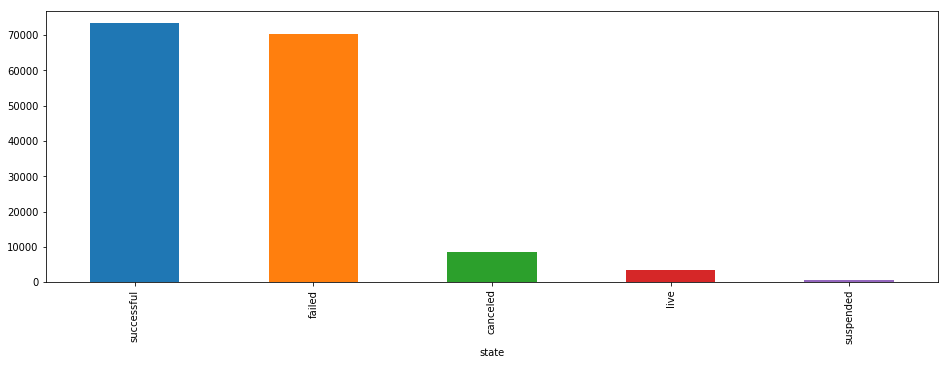

In [78]:
project_state_grp = kick_df.groupby('state')['id'].count().sort_values(ascending=False)
project_state_grp.plot(kind='bar')

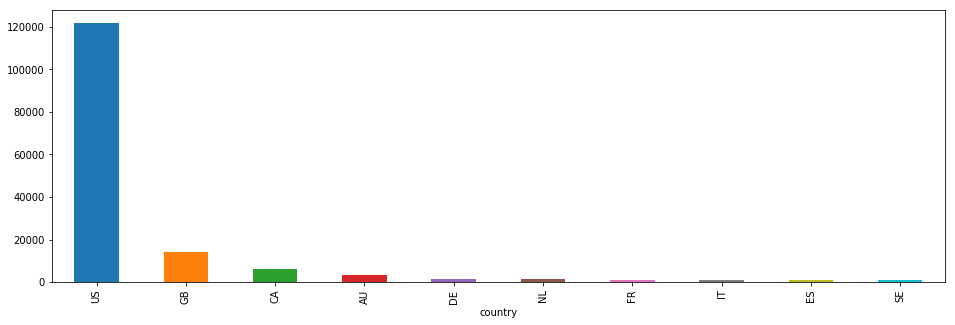

In [76]:
country_grp = kick_df.groupby('country')['id'].count()
country_grp = country_grp.sort_values(ascending=False)
country_grp = country_grp.iloc[0:10]
country_grp.plot(kind='bar')

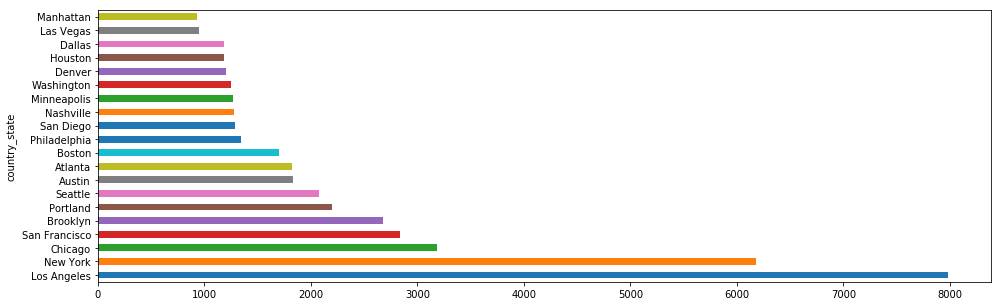

In [88]:
country_us_df = kick_df[kick_df['country'] == 'US']
country_us_state_grp = country_us_df.groupby('country_state')
country_us_state_grp = country_us_state_grp.size()
country_us_state_grp = country_us_state_grp.sort_values(ascending=False)[0:20]
country_us_state_grp.plot(kind='barh')

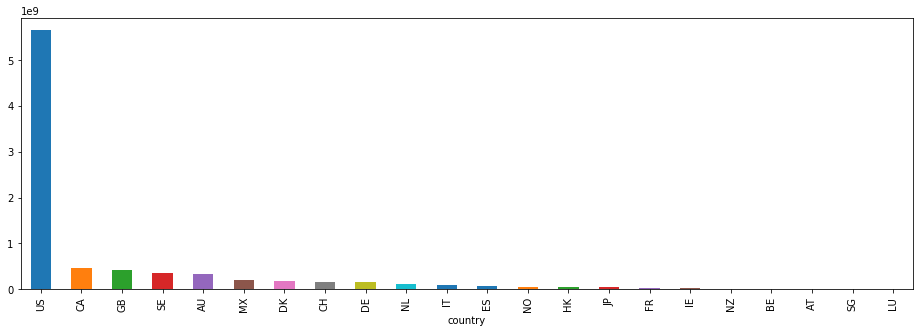

In [94]:
kick_df.groupby('country')['goal'].agg(np.sum).sort_values(ascending=False).plot(kind='bar')

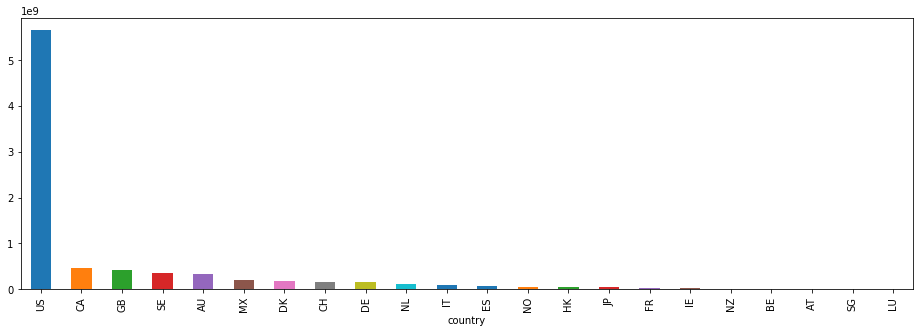

In [95]:
kick_df.groupby('country')['pledged'].agg(np.sum).sort_values(ascending=False).plot(kind='bar')

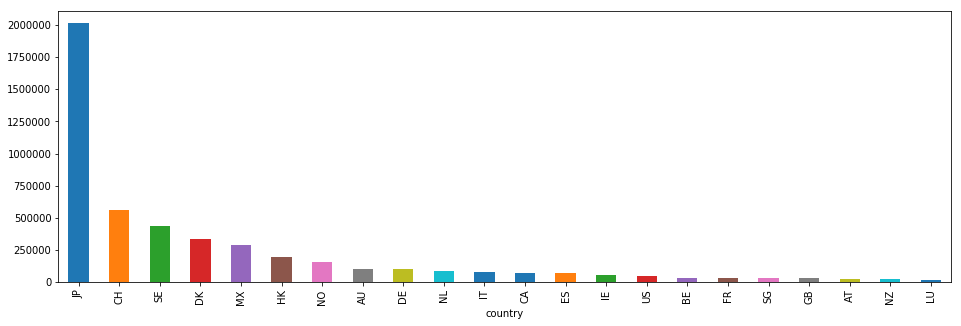

In [97]:
kick_df.groupby('country')['goal'].agg(np.mean).sort_values(ascending=False).plot(kind='bar')

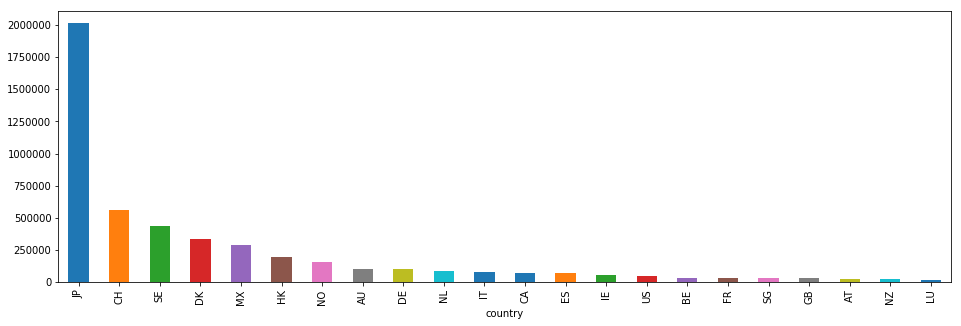

In [96]:
kick_df.groupby('country')['pledged'].agg(np.mean).sort_values(ascending=False).plot(kind='bar')

### Goal vs Pledged Histogram

In [153]:
kick_df['goal'].describe()

count       156,446.00
mean         53,866.84
std       1,336,816.05
min               0.01
25%           1,800.00
50%           5,000.00
75%          15,000.00
max     100,000,000.00
Name: goal, dtype: float64

In [136]:
kick_df['usd_pledged'].describe()

count       156,446.00
mean         53,866.84
std       1,336,816.05
min               0.01
25%           1,800.00
50%           5,000.00
75%          15,000.00
max     100,000,000.00
Name: usd_pledged, dtype: float64

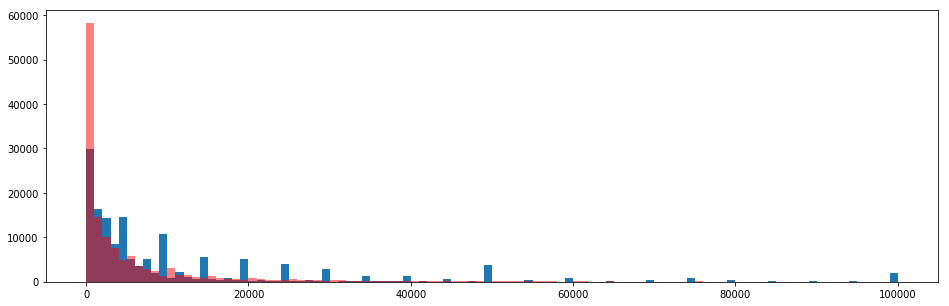

In [222]:
plt.hist(kick_df['goal'], bins=100, range=(1,100000))
plt.hist(kick_df['usd_pledged'], bins=100, range=(1,100000),alpha=0.5,color='r')
plt.show()

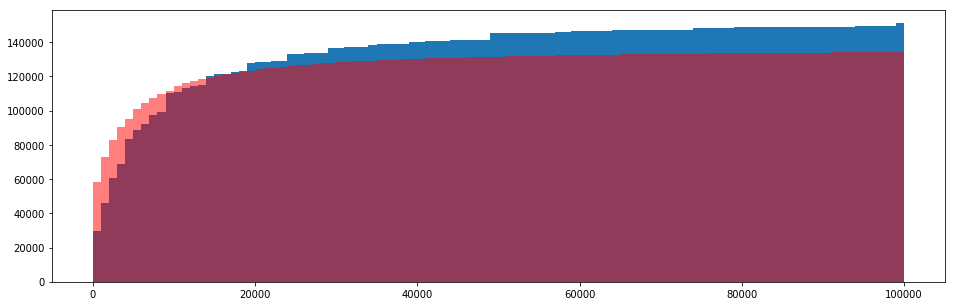

In [223]:
plt.hist(kick_df['goal'], bins=100, range=(1,100000), cumulative=True)
plt.hist(kick_df['usd_pledged'], bins=100, range=(1,100000), alpha=0.5, color='r', cumulative=True)
plt.show()

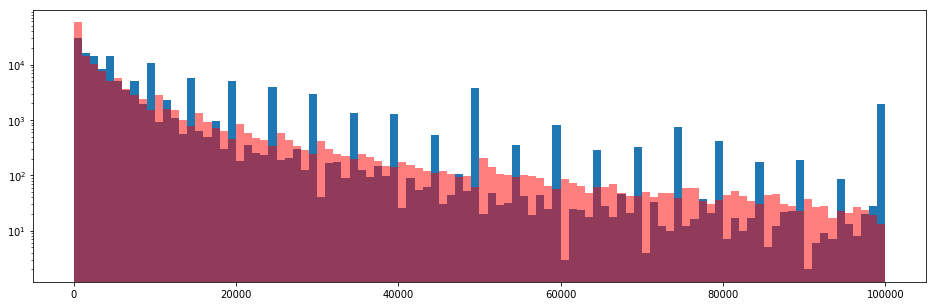

In [163]:
plt.hist(kick_df['goal'], bins=100, range=(1,100000), log=True)
plt.hist(kick_df['usd_pledged'], bins=100, range=(1,100000), alpha=0.5, color='r',log=True)
plt.show()

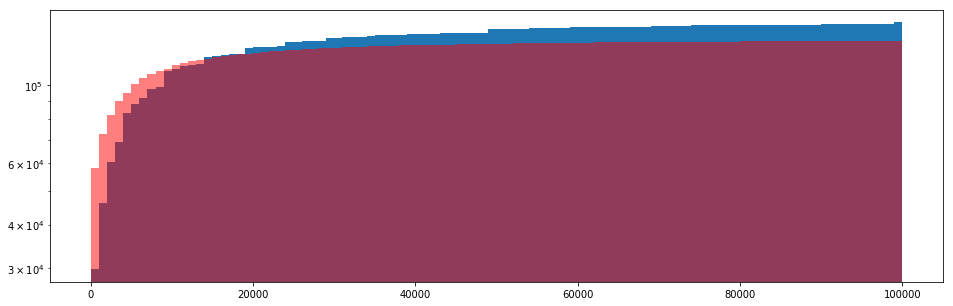

In [164]:
plt.hist(kick_df['goal'], bins=100, range=(1,100000), log=True,cumulative=True)
plt.hist(kick_df['usd_pledged'], bins=100, range=(1,100000), alpha=0.5, color='r',log=True,cumulative=True)
plt.show()

In [208]:
pledge_df = kick_df[kick_df['usd_pledged'] > 0]

In [209]:
print('%d project didn\'t get funding' % (len(kick_df) - len(pledge_df)))

19537 project didn't get funding


In [210]:
kick_df.isnull().sum()

id                              0
deadline                        0
launched_at                     0
state                           0
location_type                   0
backers_count                   0
currency                        0
goal                            0
pledged                         0
spotlight                       0
static_usd_rate                 0
usd_pledged                     0
country                         0
country_state                   0
category_type                   0
category_subtype                0
percentage_goal_reached    136909
dtype: int64

In [216]:
kick_df['percentage_goal_reached'] = kick_df['percentage_goal_reached'].fillna(0)

In [217]:
kick_df.isnull().sum()

id                         0
deadline                   0
launched_at                0
state                      0
location_type              0
backers_count              0
currency                   0
goal                       0
pledged                    0
spotlight                  0
static_usd_rate            0
usd_pledged                0
country                    0
country_state              0
category_type              0
category_subtype           0
percentage_goal_reached    0
dtype: int64

In [218]:
kick_df['percentage_goal_reached'] = pledge_df['goal'] / pledge_df['usd_pledged'] * 100

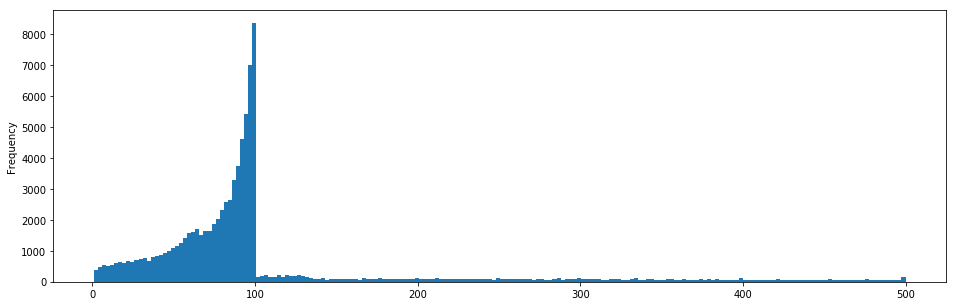

In [220]:
kick_df['percentage_goal_reached'].plot(kind='hist',range=(1,500),bins=200)

In [221]:
kick_df['percentage_goal_reached'].describe()

count          136,909.00
mean           910,736.41
std         86,084,069.14
min                  0.00
25%                 81.21
50%                 99.77
75%              2,334.18
max     19,915,498,217.58
Name: percentage_goal_reached, dtype: float64